<a href="https://colab.research.google.com/github/rkp74/Smart_Transportation_System/blob/main/Taxi_Trajectory_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset Link:- https://www.kaggle.com/competitions/pkdd-15-predict-taxi-service-trajectory-i/data

In [1]:
import os
import csv
import pandas as pd
import numpy as np
# used for linear stack of layers
from keras.models import Sequential
# type of layer that is used for fully connected neural networks
from keras.layers import Dense
# layer that flattens the input data
from keras.layers import Flatten
# convert integer class labels into one-hot encoded vectors
from keras.utils import to_categorical

In [2]:
# Connecting Google Drive with Google Colab
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
data = pd.read_csv('/content/drive/My Drive/Smart_Transportation_System/Dataset/train.csv')

In [4]:
data.head()

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[..."
1,1372637303620000596,B,NaN,7.0,20000596,1372637303,A,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[..."
2,1372636951620000320,C,NaN,NaN,20000320,1372636951,A,False,"[[-8.612964,41.140359],[-8.613378,41.14035],[-..."
3,1372636854620000520,C,NaN,NaN,20000520,1372636854,A,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[..."
4,1372637091620000337,C,NaN,NaN,20000337,1372637091,A,False,"[[-8.645994,41.18049],[-8.645949,41.180517],[-..."


In [5]:
data.shape

(1710670, 9)

In [6]:
# CALL_TYPE: (char) It identifies the way used to demand this service. It may contain one of three possible values:
# ‘A’ if this trip was dispatched from the central;
# ‘B’ if this trip was demanded directly to a taxi driver on a specific stand;
# ‘C’ otherwise (i.e. a trip demanded on a random street).

In [7]:
# b --> new data frame that only contains call type = B.
b = data.loc[data['CALL_TYPE']=='B']

# new DataFrame "no_nan" that only contains rows where the ORIGIN_STAND column is not null.
no_nan = b.loc[b['ORIGIN_STAND'].isnull() == False]

# new DataFrame "not_missing" that only contains rows where the MISSING_DATA column is False.
not_missing = no_nan.loc[no_nan['MISSING_DATA'] == False]
data = not_missing

# dropping columns ["TRIP_ID", "CALL_TYPE", "ORIGIN_CALL", "DAY_TYPE", "MISSING_DATA"]
tempData = data.drop(columns = ["TRIP_ID", "CALL_TYPE", "ORIGIN_CALL", "DAY_TYPE", "MISSING_DATA"])
data = tempData

In [8]:
data.shape

(806576, 4)

In [9]:
data.head()

,ORIGIN_STAND,TAXI_ID,TIMESTAMP,POLYLINE
1,7.0,20000596,1372637303,"[[-8.639847,41.159826],[-8.640351,41.159871],[..."
15,13.0,20000497,1372637610,"[[-8.585145,41.164857],[-8.584146,41.164704],[..."
16,28.0,20000403,1372638481,"[[-8.584263,41.163156],[-8.584695,41.163003],[..."
23,38.0,20000309,1372639960,"[[-8.60418,41.160969],[-8.603874,41.1615],[-8...."
28,52.0,20000178,1372639635,"[[-8.613243,41.154444],[-8.612811,41.153733],[..."


In [10]:
# function is used to find the index of the second-last occurrence of a given pattern in a string.
def findsecondlast(text, pattern):
    return text.rfind(pattern, 0, text.rfind(pattern))

In [11]:
# convert dataframe into numpy array
npdata = data.to_numpy()

#print(npdata.shape)

# creates an empty NumPy array called tripTime with shape (806576,1).
tripTime = np.empty(shape=(806576,1))

# creates a list called tempdata that contains the values in the fourth column of npdata.
tempdata = npdata[:, 3].tolist()

# removes the square brackets from each element in tempdata.
tempdata = [a.replace("[", "").replace("]","") for a in tempdata]

#print(len(tempdata))

# calculates the trip time for the current row by counting the number of commas in the string, adding one,
# dividing by two, and then multiplying by 15.
# This assumes that each pair of coordinates in the string represents a location visited during the trip,
# and that the time between each pair of coordinates is 15 seconds.
for i, string in enumerate(tempdata):
    tripTime[i] = (string.count(',')+1)/2.0 * 15

    # line calls the findsecondlast function to find the index of the second-last comma in the string, 
    # and then adds one to get the index of the character immediately after the second-last comma.
    secondlastcomma = findsecondlast(string, ',') + 1
    lastcor = np.fromstring(string[secondlastcomma:], dtype = 'float32', sep = ',')
    tempdata[i] = lastcor

tempdata = np.array(tempdata)

# replaces the fourth column of npdata with the values from the tempdata NumPy array.
npdata[:,3] = tempdata
print(npdata.shape)
print(tripTime.shape)
print(tripTime)

# line appends the tripTime NumPy array as an additional column to npdata.
npdata = np.append(npdata, tripTime, axis = 1)
print(npdata.shape)
print(npdata)

<ipython-input-11-d9faacd6479a>:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  tempdata = np.array(tempdata)


(806576, 4)
(806576, 1)
[[ 285.]
 [ 960.]
 [ 975.]
 ...
 [1065.]
 [ 930.]
 [ 405.]]
(806576, 5)
[[7.0 20000596 1372637303 array([-8.66574, 41.17067], dtype=float32)
  285.0]
 [13.0 20000497 1372637610 array([-8.628147, 41.15752 ], dtype=float32)
  960.0]
 [28.0 20000403 1372638481 array([-8.641566, 41.142673], dtype=float32)
  975.0]
 ...
 [9.0 20000121 1404155105 array([-8.67015 , 41.236866], dtype=float32)
  1065.0]
 [12.0 20000248 1404141826 array([-8.587026, 41.173523], dtype=float32)
  930.0]
 [34.0 20000079 1404157147 array([-8.620893, 41.14988 ], dtype=float32)
  405.0]]


In [12]:
# sorts the npdata NumPy array based on two columns: Taxi Driver ID  and Timestamp 

# uses NumPy's lexsort function to sort the rows of npdata based on the two columns specified in the input tuple.
indices = np.lexsort((npdata[:, 2], npdata[:, 1]))
print(indices.shape)
# creates a new NumPy array called sortdata by indexing into npdata with the indices array, which effectively sorts npdata based on the specified columns
sortdata = npdata[indices]
print(sortdata)
npdata = sortdata

(806576,)
[[28.0 20000001 1372662403 array([-8.607537, 41.162285], dtype=float32)
  300.0]
 [63.0 20000001 1372669154 array([-8.593308, 41.147964], dtype=float32)
  540.0]
 [10.0 20000001 1372676157 array([-8.565732, 41.174713], dtype=float32)
  780.0]
 ...
 [61.0 20000904 1404160289 array([-8.623017, 41.15016 ], dtype=float32)
  330.0]
 [61.0 20000904 1404164541 array([-8.579934, 41.159485], dtype=float32)
  645.0]
 [53.0 20000904 1404165869 array([-8.606925, 41.152473], dtype=float32)
  390.0]]


In [13]:
sortdata2 = npdata.copy()
for i in range(0,806575):
    # sets the value in the first column of the current row to be the value in the first column of the next row. 
    # This effectively shifts the driver ID up by one row for all rows except the last one.
    sortdata2[i, 0] = sortdata2[i+1, 0]
for i in range(806575,0, -1):
    # sets the value in the fourth column of the current row to be the value in the fourth column of the previous row. 
    # This effectively shifts the trip time down by one row for all rows except the first one.
    sortdata2[i, 3] = sortdata2[i-1, 3]
print(sortdata2)

[[63.0 20000001 1372662403 array([-8.607537, 41.162285], dtype=float32)
  300.0]
 [10.0 20000001 1372669154 array([-8.607537, 41.162285], dtype=float32)
  540.0]
 [25.0 20000001 1372676157 array([-8.593308, 41.147964], dtype=float32)
  780.0]
 ...
 [61.0 20000904 1404160289 array([-8.574624, 41.15666 ], dtype=float32)
  330.0]
 [53.0 20000904 1404164541 array([-8.623017, 41.15016 ], dtype=float32)
  645.0]
 [53.0 20000904 1404165869 array([-8.579934, 41.159485], dtype=float32)
  390.0]]


In [14]:
# Focused on filtering out rows of data where a driver only has one trip

# copy of sortdata2, but with the first row removed.
cleandata = np.delete(sortdata2, 0, 0)
# removes the last row of cleandata
cleandata = np.delete(cleandata, 806574, 0)
# initializes a variable called firstDriver to be the driver ID of the first row of cleandata.
firstDriver = cleandata[0, 1]
# array is initialized with all values set to 1 as same length as cleandata
not_to_delete = np.ones(806574)
# Identify and remove duplicate rows based on a specific column
for i in range(0,806573):
    # checks if the driver ID in the current row is different from the driver ID in the previous row.
    # If it is, this indicates that the previous driver only had one trip, 
    # so the current row and the previous row should both be marked for deletion.
    if cleandata[i, 1] != firstDriver:
        firstDriver = cleandata[i, 1]
        not_to_delete[i] = 0
        not_to_delete[i-1] = 0

# prints the number of rows that will be deleted from cleandata.
print(806574 - np.sum(not_to_delete))
# converts the not_to_delete array from a numeric array to a boolean array.
not_to_delete = not_to_delete.astype('bool')
cleandata = cleandata[not_to_delete]
# Print the final cleaned data
print(cleandata.shape)
print(cleandata)

876.0
(805698, 5)
[[10.0 20000001 1372669154 array([-8.607537, 41.162285], dtype=float32)
  540.0]
 [25.0 20000001 1372676157 array([-8.593308, 41.147964], dtype=float32)
  780.0]
 [30.0 20000001 1372683156 array([-8.565732, 41.174713], dtype=float32)
  825.0]
 ...
 [61.0 20000904 1404157116 array([-8.59797, 41.15439], dtype=float32)
  465.0]
 [61.0 20000904 1404160289 array([-8.574624, 41.15666 ], dtype=float32)
  330.0]
 [53.0 20000904 1404164541 array([-8.623017, 41.15016 ], dtype=float32)
  645.0]]


In [15]:
# Mean value of Triptime
print(np.mean(cleandata[:,4]))

678.8493796683124


In [16]:
# This code is cleaning the data by removing any rows where the timestamp difference between the current row and the previous row,
# plus the previous row's duration, is greater than 30 minutes (8839 seconds).

# Create an array of ones with the same number of rows as the original cleaned data
not_to_delete = np.ones(805698)
# Get the value in the second column of the first row of the cleaned data
firstDriver = cleandata[0, 1]

# Loop through each row of the cleaned data
for i in range(1, 805698):
  # If the value in the second column of this row is not equal to firstDriver
    if cleandata[i,1] != firstDriver:
      # Update the value of firstDriver to be the current row's second column value
        firstDriver = cleandata[i,1]
        continue
         # Calculate the difference between the current row's timestamp and the previous row's timestamp
    # plus the previous row's duration, and check if it is greater than 8839 (30 minutes)
    
    if cleandata[i, 2] - cleandata[i-1, 2] - cleandata[i-1,4] > 8839:   #check if the timestamps differ by more than 30 minutes
    # Set the value in the not_to_delete array at index i to zero
        not_to_delete[i] = 0
# Calculate and print the number of rows that were flagged for deletion
print(np.sum(not_to_delete))
# Create a copy of the original cleaned data
cleandata2 = cleandata.copy()


# Convert not_to_delete to a boolean array
not_to_delete = not_to_delete.astype(np.bool)

# Use not_to_delete as a mask to remove flagged rows from cleandata2
cleandata2 = cleandata2[not_to_delete]

# Print the final cleaned data
print(cleandata2.shape)
print(cleandata2)

505328.0
(505328, 5)
[[10.0 20000001 1372669154 array([-8.607537, 41.162285], dtype=float32)
  540.0]
 [25.0 20000001 1372676157 array([-8.593308, 41.147964], dtype=float32)
  780.0]
 [30.0 20000001 1372683156 array([-8.565732, 41.174713], dtype=float32)
  825.0]
 ...
 [61.0 20000904 1404071729 array([-8.612955, 41.137722], dtype=float32)
  345.0]
 [61.0 20000904 1404160289 array([-8.574624, 41.15666 ], dtype=float32)
  330.0]
 [53.0 20000904 1404164541 array([-8.623017, 41.15016 ], dtype=float32)
  645.0]]


<ipython-input-16-d2030aaa58e6>:29: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  not_to_delete = not_to_delete.astype(np.bool)


In [17]:
## this code is sorting the cleaned data first by the second column (driver ID) and then by the third column (timestamp).
## It then goes through the sorted data and groups rows by a 30-minute time interval, 
## and for each group, it calculates the number of occurrences of each stand ID within that time interval using np.bincount.

#If the counts array is not empty, it prints the tuples containing the nonzero stand IDs and their counts.

# Sort the cleaned data first by the second column (driver ID) and then by the third column (timestamp)
sorted_indices = np.lexsort((cleandata2[:,2], cleandata2[:,1]))

# Print the shape of the sorted indices array
print(sorted_indices.shape)

# Use the sorted indices to rearrange the rows of the cleaned data in order of timestamp and driver ID
sorted_by_timestamp = cleandata2[sorted_indices]
# to_order = cleandata2.copy()
# dtype = [("stand", np.int), ("driver", np.int), ("timestamp", np.int), ("pos", np.ndarray), ("drive_time", np.int)]
# print(to_order.tolist())
# to_order = np.array(to_order.tolist(), dtype=dtype)
# to_order.astype(dtype)
# np.append([['stand', 'driver', 'timestamp', 'pos', 'drive_time']],to_order, axis=0)
# np.sort(to_order, order='timestamp')
# print(to_order)
# print(sorted_by_timestamp)
first_timestamp = sorted_by_timestamp[0][2]
start_index = 0
end_index = 0
for i in range(sorted_by_timestamp.shape[0]):
#     print(sorted_by_timestamp[i][2])
    if sorted_by_timestamp[i][2] - first_timestamp < 1800:
        end_index = i
    else:
#         print(start_index, end_index)
#         print(first_timestamp, sorted_by_timestamp[i][2])
        # If start_index and end_index are equal, move start_index to the next row and continue to the next iteration
        if(start_index == end_index):
            start_index = end_index + 1
            first_timestamp = sorted_by_timestamp[i][2]
            continue
             # Otherwise, print the difference between start_index and end_index
        print(start_index - end_index)
                # Get the values in the first column (stand ID) for all rows between start_index and end_index (exclusive)
        stands = sorted_by_timestamp[start_index:end_index, 0]
        # Convert the stand IDs to integers
        stands = stands.astype(np.int)
                # Use bincount to count the number of occurrences of each stand ID
        my = np.bincount(stands)
                # Get the indices of all nonzero counts
        ii = np.nonzero(my)[0]
        # Create an array of tuples where each tuple contains a nonzero stand ID and its count
        counts = np.vstack((ii, my[ii])).T
        # If the counts array is not empty, print it
        if counts.size != 0:
            print(counts)

        start_index = end_index + 1
          # Set first_timestamp to be the timestamp of the current row
        first_timestamp = sorted_by_timestamp[i][2]

(505328,)
1
1
1
-4
[[19  1]
 [25  1]
 [30  1]
 [61  1]]
1
1
1
1
1
1
1
-8
[[ 7  1]
 [16  1]
 [19  3]
 [25  1]
 [30  1]
 [37  1]]
1
1
1
1
1
1
1
1
1
1
1
-12
[[ 7  1]
 [10  1]
 [19  4]
 [25  1]
 [28  1]
 [42  2]
 [58  2]]
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
-22
[[16  1]
 [17  1]
 [19  4]
 [25  2]
 [26  1]
 [28  5]
 [29  1]
 [30  1]
 [37  1]
 [40  1]
 [52  1]
 [53  2]
 [63  1]]
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
-17
[[10  1]
 [12  1]
 [15  1]
 [19  5]
 [23  1]
 [25  1]
 [27  2]
 [28  4]
 [34  1]]
1
-2
[[19  2]]
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
-21
[[ 7  1]
 [10  1]
 [17  1]
 [19  8]
 [22  1]
 [25  1]
 [28  3]
 [30  2]
 [36  1]
 [37  1]
 [62  1]]
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
-30
[[10  1]
 [12  1]
 [19  6]
 [28  4]
 [29  1]
 [30  3]
 [32  1]
 [36  2]
 [37  1]
 [47  1]
 [51  1]
 [52  1]
 [56  1]
 [58  1]
 [62  4]
 [63  1]]
1
1
1
1
1
1
1
1
-9
[[10  1]
 [17  1]
 [28  3]
 [30  1]
 [39  1]
 [52  1]
 [62  1]]
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1

<ipython-input-17-7615bc1a4423>:44: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  stands = stands.astype(np.int)



1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
-149
[[ 7  1]
 [10  8]
 [11  1]
 [14  1]
 [17  1]
 [19 48]
 [23  1]
 [25  4]
 [26  2]
 [27  1]
 [28 31]
 [29  1]
 [30  5]
 [32  1]
 [33  2]
 [34  3]
 [35  3]
 [37  4]
 [40  1]
 [45  1]
 [49  3]
 [50  1]
 [52  3]
 [54  2]
 [58  1]
 [60  1]
 [62  4]
 [63 14]]
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
-78
[[ 7  1]
 [19 13]
 [22  1]
 [25  1]
 [27  1]
 [28  4]
 [30  5]
 [31  1]
 [32  7]
 [34  5]
 [35  1]
 [37  2]
 [52  5]
 [53  1]
 [54  8]
 [58  1]
 [60  1]
 [63 20]]
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
-22
[[17  1]
 [19  8]
 [23  1]
 [27  1]
 [30  2]
 [31  1]
 [32  1]
 [34  1]
 [42  1]
 [60  1]
 [63  4]]
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
-23
[[18  1]
 [19  5]
 [25  2]
 [27  1]
 [32  2]
 [33 

In [18]:
# Initialize a counter variable to zero
ctr = 0
# Create an array of ones with the same shape as cleandata2
temparray = np.ones(shape = (cleandata2.shape[0], ))

# Loop through each row in cleandata2
for i in range(cleandata2.shape[0]):
    # If the fourth column of the current row is an empty array
    if cleandata2[i, 3].shape[0] == 0:
        # Set the corresponding value in temparray to zero
        temparray[i] = 0

# Print the shape of cleandata2
print(cleandata2.shape)
# Convert temparray to a boolean array
temparray = temparray.astype('bool')
# Use temparray to filter cleandata2 (i.e., remove rows where the corresponding value in temparray is False)
cleandata2 = cleandata2[temparray]
# Print the shape of the filtered cleandata2
print(cleandata2.shape)
# Print the value of the counter variable
print(ctr)

(505328, 5)
(504305, 5)
0


In [21]:
import datetime

x_train = np.empty(shape = (504305,), dtype='object')
location = np.empty(shape = (504305,2))
for i in range(504305):
    loc = cleandata2[i, 3]
    lat = loc[0]
    lon = loc[1]
    location[i, 0] = lat
    location[i, 1] = lon
x_train = x_train[:, np.newaxis]
x_train = np.append(x_train, location, axis = 1)
# print(x_train.shape)
y_train = cleandata2[:, 0].astype('int32')
print(y_train.shape)

timee = np.empty(shape = (504305,4), dtype='int32')

for i in range(cleandata2.shape[0]):
    ts = datetime.datetime.fromtimestamp(cleandata2[i][2])
    timee[i, 0] = ts.month
    timee[i, 1] = ts.day
    timee[i, 2] = ts.hour
    timee[i, 3] = ts.minute



x_train = np.delete(x_train, 0, 1)
x_train = np.append(x_train, timee, axis = 1)
# x_train = x_train.astype('float32')
print(x_train.shape)
print(x_train)

(504305,)
(504305, 6)
[[-8.607537269592285 41.16228485107422 7 1 8 59]
 [-8.593308448791504 41.14796447753906 7 1 10 55]
 [-8.5657320022583 41.174713134765625 7 1 12 52]
 ...
 [-8.612955093383789 41.13772201538086 6 29 19 55]
 [-8.574624061584473 41.15665817260742 6 30 20 31]
 [-8.623017311096191 41.15016174316406 6 30 21 42]]


In [22]:
y_train = to_categorical(y_train)
y_train = np.delete(y_train, 0 ,1)
print(y_train.shape)
print(y_train)

(504305, 63)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [23]:
print(x_train[0])

[-8.607537269592285 41.16228485107422 7 1 8 59]


In [24]:
def stand_to_img_coords(stand_id):
    pass

over_x = cleandata2[:10000,:]

sorted_indices = np.lexsort((over_x[:,2], over_x[:,1]))
print(sorted_indices.shape)
sorted_by_timestamp = cleandata2[sorted_indices]
# to_order = cleandata2.copy()
# dtype = [("stand", np.int), ("driver", np.int), ("timestamp", np.int), ("pos", np.ndarray), ("drive_time", np.int)]
# print(to_order.tolist())
# to_order = np.array(to_order.tolist(), dtype=dtype)
# to_order.astype(dtype)
# np.append([['stand', 'driver', 'timestamp', 'pos', 'drive_time']],to_order, axis=0)
# np.sort(to_order, order='timestamp')
# print(to_order)
# print(sorted_by_timestamp)
first_timestamp = sorted_by_timestamp[0][2]
start_index = 0
end_index = 0
for i in range(sorted_by_timestamp.shape[0]):
#     print(sorted_by_timestamp[i][2])
    if sorted_by_timestamp[i][2] - first_timestamp < 1800:
        end_index = i
    else:
#         print(start_index, end_index)
#         print(first_timestamp, sorted_by_timestamp[i][2])
        if(start_index == end_index):
            start_index = end_index + 1
            first_timestamp = sorted_by_timestamp[i][2]
            continue
#         print(start_index - end_index)
        stands = sorted_by_timestamp[start_index:end_index, 0]
        stands = stands.astype(np.int)
        my = np.bincount(stands)
        ii = np.nonzero(my)[0]
        counts = np.vstack((ii, my[ii])).T
        if counts.size != 0:
            #do the computation relating to putting the largest stands on the map
            
            pass

        start_index = end_index + 1
        first_timestamp = sorted_by_timestamp[i][2]

(10000,)


<ipython-input-24-1258aa02171b>:34: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  stands = stands.astype(np.int)


Streaming output truncated to the last 5000 lines.
20/20 [==============================] - 0s 4ms/step - loss: 0.3216 - accuracy: 0.9072
Epoch 502/3000
20/20 [==============================] - 0s 5ms/step - loss: 0.3291 - accuracy: 0.9044
Epoch 503/3000
20/20 [==============================] - 0s 4ms/step - loss: 0.3485 - accuracy: 0.8967
Epoch 504/3000
20/20 [==============================] - 0s 4ms/step - loss: 0.3826 - accuracy: 0.8858
Epoch 505/3000
20/20 [==============================] - 0s 4ms/step - loss: 0.3748 - accuracy: 0.8904
Epoch 506/3000
20/20 [==============================] - 0s 5ms/step - loss: 0.3681 - accuracy: 0.8836
Epoch 507/3000
20/20 [==============================] - 0s 4ms/step - loss: 0.3504 - accuracy: 0.8929
Epoch 508/3000
20/20 [==============================] - 0s 4ms/step - loss: 0.3178 - accuracy: 0.9026
Epoch 509/3000
20/20 [==============================] - 0s 5ms/step - loss: 0.2874 - accuracy: 0.9124
Epoch 510/3000
20/20 [========================

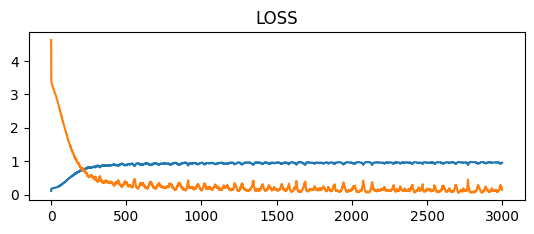

In [26]:
import matplotlib.pyplot as plt
import keras.optimizers
import keras
from keras.callbacks import ModelCheckpoint

print(x_train[0])
over_x = x_train[:10000,].astype(np.float32)
# meow = np.zeros(63)
# meow[5] = 1
over_y = y_train[:10000,].astype(np.float32)
print(over_x.shape)
print(over_y.shape)
print(over_x)
print(over_y)

# print(x_train.shape)
model = Sequential()
# model.add(Dense(10000, input_shape = (3,), activation  = 'relu'))
model.add(Dense(128, input_dim=6, activation  = 'relu', kernel_initializer='glorot_uniform'))
model.add(Dense(256, kernel_initializer='glorot_uniform', activation  = 'relu'))
model.add(Dense(1024, kernel_initializer='glorot_uniform', activation  = 'relu'))
# model.add(Dense(2048, kernel_initializer='glorot_uniform', activation  = 'relu'))
# model.add(Dense(64))
#model.add(Flatten())
model.add(Dense(63, activation = 'softmax'))
model.summary()

# model.summary()
adam = keras.optimizers.Adam(lr=0.0019)#lr = 0.0019
# sgd = keras.optimizers.SGD(lr=0.001, momentum=0.0, decay=0.0, nesterov=False)
# model.compile(loss = keras.losses.categorical_crossentropy, optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True), metrics = ['accuracy'])
model.compile(loss = keras.losses.categorical_crossentropy, optimizer = adam, metrics = ['accuracy'])
# history = model.fit(x_train, y_train, validation_split = 0.1, epochs = 10, batch_size = 128)
# history = model.fit(over_x, over_y, validation_split = 0.1, epochs = 1000, batch_size = 512, verbose=1)
history = model.fit(over_x, over_y, epochs = 3000, batch_size = 512, verbose=1)
model.save('final_weights.h5')
plt.subplot(211)
plt.title("LOSS")
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])